In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

# Insert Data

In [2]:
file_path = "/kaggle/input/predicta-1-0-predict-the-unpredictable/historical_weather.csv" 
df = pd.read_csv(file_path)

In [3]:
test_file_path = "/kaggle/input/predicta-1-0-predict-the-unpredictable/submission_key.csv"
test_data = pd.read_csv(test_file_path)
ids = test_data.pop('submission_ID')

In [4]:
df

,city_id,date,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,avg_wind_speed_kmh
0,C001,2014-01-01,6.6,-1.4,11.6,NaN,NaN,168.0,6.2
1,C001,2014-01-02,9.3,6.3,13.3,NaN,NaN,155.0,10.0
2,C001,2014-01-03,7.6,1.9,14.0,NaN,NaN,NaN,5.8
3,C001,2014-01-04,7.6,3.9,13.3,NaN,NaN,291.0,11.3
4,C001,2014-01-05,8.6,0.5,16.9,NaN,NaN,NaN,5.0
...,...,...,...,...,...,...,...,...,...
182333,C112,2018-12-27,22.0,15.9,27.9,0.0,NaN,100.0,13.2
182334,C112,2018-12-28,21.9,14.9,28.2,0.0,NaN,91.0,12.6
182335,C112,2018-12-29,22.4,16.3,28.2,0.0,NaN,61.0,14.2
182336,C112,2018-12-30,21.6,18.5,26.6,1.6,NaN,70.0,17.0


In [5]:
test_data

,city_id,date
0,C001,2019-01-01
1,C001,2019-01-02
2,C001,2019-01-03
3,C001,2019-01-04
4,C001,2019-01-05
...,...,...
695,C112,2019-01-03
696,C112,2019-01-04
697,C112,2019-01-05
698,C112,2019-01-06


# Unique Data count for each column

In [6]:
df.nunique()

city_id                100
date                  1826
avg_temp_c             692
min_temp_c             720
max_temp_c             705
precipitation_mm       859
snow_depth_mm          407
avg_wind_dir_deg       361
avg_wind_speed_kmh     582
dtype: int64

# Custom Description

In [7]:
def customDescription(df: pd.DataFrame, numeric_only: bool = False):
    if numeric_only:
        df = df.select_dtypes(include=np.number)
    
    desc = pd.DataFrame(index=df.columns.to_list())
    desc['type'] = df.dtypes
    desc['count'] = df.count()
    desc['nunique'] = df.nunique()
    desc['null'] = df.isnull().sum()
    
    # Handle numeric columns separately
    if not df.select_dtypes(include=np.number).empty:
        numeric_desc = df.describe().T.drop(columns=['count','std','25%','50%','75%'], axis=1)
        for col in df.select_dtypes(include=np.number).columns:
            desc.loc[col, 'mean'] = numeric_desc.loc[col, 'mean']
            desc.loc[col, 'min'] = numeric_desc.loc[col, 'min']
            desc.loc[col, 'max'] = numeric_desc.loc[col, 'max']
    
    # Handle non-numeric columns separately
    if not df.select_dtypes(exclude=np.number).empty:
        non_numeric_desc = df.select_dtypes(exclude=np.number).describe().T
        desc = pd.concat([desc, non_numeric_desc.drop(columns=['count', 'unique', 'top', 'freq'], axis=1, errors='ignore')], axis=1)
    
    return desc

In [8]:
customDescription(df)

,type,count,nunique,null,mean,min,max
city_id,object,182338,100,0,NaN,NaN,NaN
date,object,182338,1826,0,NaN,NaN,NaN
avg_temp_c,float64,181114,692,1224,19.137516,-34.7,41.9
min_temp_c,float64,176452,720,5886,14.627775,-43.8,38.9
max_temp_c,float64,174845,705,7493,23.887261,-28.5,49.1
precipitation_mm,float64,112594,859,69744,3.679964,0.0,496.1
snow_depth_mm,float64,12238,407,170100,342.481696,0.0,7140.0
avg_wind_dir_deg,float64,146944,361,35394,175.650289,0.0,360.0
avg_wind_speed_kmh,float64,159866,582,22472,11.281875,0.0,80.0


# Handling Null Values in avg_temp_c

In [9]:
# Step 1: Identify NaN rows in avg_temp_c
df1 = df.copy()
nan_rows = df1[df1['avg_temp_c'].isna()]

deleted_rows_count = 0

for index, row in nan_rows.iterrows():
    min_temp = row['min_temp_c']
    max_temp = row['max_temp_c']
    
    if pd.isna(min_temp) or pd.isna(max_temp):
        deleted_rows_count += 1
    else:
        df1.at[index, 'avg_temp_c'] = (min_temp + max_temp) / 2

df1.dropna(subset=['avg_temp_c'], inplace=True) 
print(f"Number of rows deleted: {deleted_rows_count}")

Number of rows deleted: 25


In [10]:
customDescription(df1)

,type,count,nunique,null,mean,min,max
city_id,object,182313,100,0,NaN,NaN,NaN
date,object,182313,1826,0,NaN,NaN,NaN
avg_temp_c,float64,182313,1099,0,19.080045,-34.7,41.9
min_temp_c,float64,176441,720,5872,14.628773,-43.8,38.9
max_temp_c,float64,174843,705,7470,23.887492,-28.5,49.1
precipitation_mm,float64,112577,859,69736,3.680301,0.0,496.1
snow_depth_mm,float64,12229,407,170084,342.655246,0.0,7140.0
avg_wind_dir_deg,float64,146943,361,35370,175.650824,0.0,360.0
avg_wind_speed_kmh,float64,159859,582,22454,11.281575,0.0,80.0


In [11]:
df2 = df1.copy()
df2['date'] = pd.to_datetime(df2['date'])
df2['day'] = df2['date'].dt.day
df2['month'] = df2['date'].dt.month
df2['year'] = df2['date'].dt.year

In [12]:
df2

,city_id,date,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,avg_wind_speed_kmh,day,month,year
0,C001,2014-01-01,6.6,-1.4,11.6,NaN,NaN,168.0,6.2,1,1,2014
1,C001,2014-01-02,9.3,6.3,13.3,NaN,NaN,155.0,10.0,2,1,2014
2,C001,2014-01-03,7.6,1.9,14.0,NaN,NaN,NaN,5.8,3,1,2014
3,C001,2014-01-04,7.6,3.9,13.3,NaN,NaN,291.0,11.3,4,1,2014
4,C001,2014-01-05,8.6,0.5,16.9,NaN,NaN,NaN,5.0,5,1,2014
...,...,...,...,...,...,...,...,...,...,...,...,...
182333,C112,2018-12-27,22.0,15.9,27.9,0.0,NaN,100.0,13.2,27,12,2018
182334,C112,2018-12-28,21.9,14.9,28.2,0.0,NaN,91.0,12.6,28,12,2018
182335,C112,2018-12-29,22.4,16.3,28.2,0.0,NaN,61.0,14.2,29,12,2018
182336,C112,2018-12-30,21.6,18.5,26.6,1.6,NaN,70.0,17.0,30,12,2018


In [13]:
customDescription(df2)

,type,count,nunique,null,mean,min,max,mean,min,25%,50%,75%,max
city_id,object,182313,100,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
date,datetime64[ns],182313,1826,0,NaN,NaN,NaN,2016-07-02 06:44:50.743940352,2014-01-01 00:00:00,2015-04-03 00:00:00,2016-07-03 00:00:00,2017-10-02 00:00:00,2018-12-31 00:00:00
avg_temp_c,float64,182313,1099,0,19.080045,-34.7,41.9,NaN,NaN,NaN,NaN,NaN,NaN
min_temp_c,float64,176441,720,5872,14.628773,-43.8,38.9,NaN,NaN,NaN,NaN,NaN,NaN
max_temp_c,float64,174843,705,7470,23.887492,-28.5,49.1,NaN,NaN,NaN,NaN,NaN,NaN
precipitation_mm,float64,112577,859,69736,3.680301,0.0,496.1,NaN,NaN,NaN,NaN,NaN,NaN
snow_depth_mm,float64,12229,407,170084,342.655246,0.0,7140.0,NaN,NaN,NaN,NaN,NaN,NaN
avg_wind_dir_deg,float64,146943,361,35370,175.650824,0.0,360.0,NaN,NaN,NaN,NaN,NaN,NaN
avg_wind_speed_kmh,float64,159859,582,22454,11.281575,0.0,80.0,NaN,NaN,NaN,NaN,NaN,NaN
day,int32,182313,31,0,15.727737,1.0,31.0,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
new_df = df2

# City Encording

In [15]:
len(new_df['city_id'].unique())
cities = []
for c in new_df['city_id'].unique():
    cities.append(str(c))

In [16]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()

encoded_cities = encoder.fit_transform(new_df[['city_id']]).toarray()
new_df[cities] = encoded_cities

/tmp/ipykernel_33/2047495370.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[cities] = encoded_cities
/tmp/ipykernel_33/2047495370.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[cities] = encoded_cities
/tmp/ipykernel_33/2047495370.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy

In [17]:
new_df['city_avg_temp_for_month'] = new_df.groupby(['city_id', 'year', 'month'])['avg_temp_c'].transform('mean')
new_df['city_avg_max_temp_for_month'] = new_df.groupby(['city_id', 'year', 'month'])['avg_temp_c'].transform('max')
new_df['city_avg_min_temp_for_month'] = new_df.groupby(['city_id', 'year', 'month'])['avg_temp_c'].transform('min')


/tmp/ipykernel_33/1530344898.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df['city_avg_temp_for_month'] = new_df.groupby(['city_id', 'year', 'month'])['avg_temp_c'].transform('mean')
/tmp/ipykernel_33/1530344898.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df['city_avg_max_temp_for_month'] = new_df.groupby(['city_id', 'year', 'month'])['avg_temp_c'].transform('max')
/tmp/ipykernel_33/1530344898.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

In [18]:
new_df.head()

,city_id,date,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,avg_wind_speed_kmh,day,...,C106,C107,C108,C109,C110,C111,C112,city_avg_temp_for_month,city_avg_max_temp_for_month,city_avg_min_temp_for_month
0,C001,2014-01-01,6.6,-1.4,11.6,NaN,NaN,168.0,6.2,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.558065,12.0,2.8
1,C001,2014-01-02,9.3,6.3,13.3,NaN,NaN,155.0,10.0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.558065,12.0,2.8
2,C001,2014-01-03,7.6,1.9,14.0,NaN,NaN,NaN,5.8,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.558065,12.0,2.8
3,C001,2014-01-04,7.6,3.9,13.3,NaN,NaN,291.0,11.3,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.558065,12.0,2.8
4,C001,2014-01-05,8.6,0.5,16.9,NaN,NaN,NaN,5.0,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.558065,12.0,2.8


In [19]:
new_df = new_df.drop(columns=['max_temp_c','min_temp_c','snow_depth_mm','precipitation_mm','avg_wind_dir_deg','avg_wind_speed_kmh'], axis=1)

In [20]:
new_df

,city_id,date,avg_temp_c,day,month,year,C001,C002,C003,C004,...,C106,C107,C108,C109,C110,C111,C112,city_avg_temp_for_month,city_avg_max_temp_for_month,city_avg_min_temp_for_month
0,C001,2014-01-01,6.6,1,1,2014,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.558065,12.0,2.8
1,C001,2014-01-02,9.3,2,1,2014,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.558065,12.0,2.8
2,C001,2014-01-03,7.6,3,1,2014,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.558065,12.0,2.8
3,C001,2014-01-04,7.6,4,1,2014,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.558065,12.0,2.8
4,C001,2014-01-05,8.6,5,1,2014,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.558065,12.0,2.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182333,C112,2018-12-27,22.0,27,12,2018,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,20.925806,23.4,18.2
182334,C112,2018-12-28,21.9,28,12,2018,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,20.925806,23.4,18.2
182335,C112,2018-12-29,22.4,29,12,2018,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,20.925806,23.4,18.2
182336,C112,2018-12-30,21.6,30,12,2018,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,20.925806,23.4,18.2


In [21]:
customDescription(new_df)

,type,count,nunique,null,mean,min,max,mean,min,25%,50%,75%,max
city_id,object,182313,100,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
date,datetime64[ns],182313,1826,0,NaN,NaN,NaN,2016-07-02 06:44:50.743940352,2014-01-01 00:00:00,2015-04-03 00:00:00,2016-07-03 00:00:00,2017-10-02 00:00:00,2018-12-31 00:00:00
avg_temp_c,float64,182313,1099,0,19.080045,-34.700000,41.900000,NaN,NaN,NaN,NaN,NaN,NaN
day,int32,182313,31,0,15.727737,1.000000,31.000000,NaN,NaN,NaN,NaN,NaN,NaN
month,int32,182313,12,0,6.524724,1.000000,12.000000,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
C111,float64,182313,2,0,0.009977,0.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
C112,float64,182313,2,0,0.009873,0.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
city_avg_temp_for_month,float64,182313,5082,0,19.080045,-19.939286,38.112903,NaN,NaN,NaN,NaN,NaN,NaN
city_avg_max_temp_for_month,float64,182313,449,0,23.153977,-7.700000,41.900000,NaN,NaN,NaN,NaN,NaN,NaN


# Add Moving average

In [22]:
import warnings
warnings.filterwarnings("ignore")

In [23]:
new_df1 = new_df.copy()
new_df1['moving_avg_temp'] = new_df1['avg_temp_c'].rolling(window = 7,center = True,min_periods=3).mean()

# Try to use Stat Model (Not useful)

In [25]:
from statsmodels.tsa.deterministic import DeterministicProcess

cities = new_df1['city_id'].unique()
for city in cities[:4]:
    city_data = new_df1[new_df1['city_id'] == city]
    city_data = city_data.sort_values(by='date')
    city_data=city_data.drop(columns=['city_id'],axis=1)

    # Set the date column as the index
    city_data['date_indexed'] = np.arange(len(city_data.index))
    city_data = city_data.set_index('date_indexed')
    dp = DeterministicProcess(index = city_data.index,constant = True, order = 1, drop = True)
    X = dp.in_sample()
    y = city_data['avg_temp_c']
    model = LinearRegression(fit_intercept =False)
    model.fit(X,y)
    
    X = dp.out_of_sample(steps=7)
    y_fore = pd.Series(model.predict(X),index = X.index)

# Plots

## Full Time

In [26]:
new_df1['moving_avg_temp'].isna().sum()

0

13:03:26 - cmdstanpy - INFO - Chain [1] start processing
13:03:26 - cmdstanpy - INFO - Chain [1] done processing
13:03:26 - cmdstanpy - INFO - Chain [1] start processing
13:03:27 - cmdstanpy - INFO - Chain [1] done processing
13:03:28 - cmdstanpy - INFO - Chain [1] start processing
13:03:28 - cmdstanpy - INFO - Chain [1] done processing


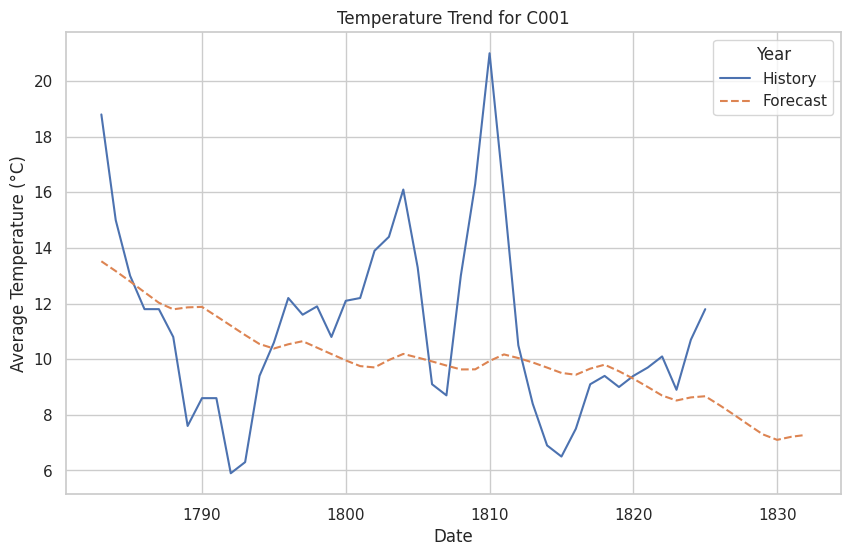

13:03:30 - cmdstanpy - INFO - Chain [1] start processing
13:03:30 - cmdstanpy - INFO - Chain [1] done processing
13:03:30 - cmdstanpy - INFO - Chain [1] start processing
13:03:31 - cmdstanpy - INFO - Chain [1] done processing
13:03:32 - cmdstanpy - INFO - Chain [1] start processing
13:03:32 - cmdstanpy - INFO - Chain [1] done processing


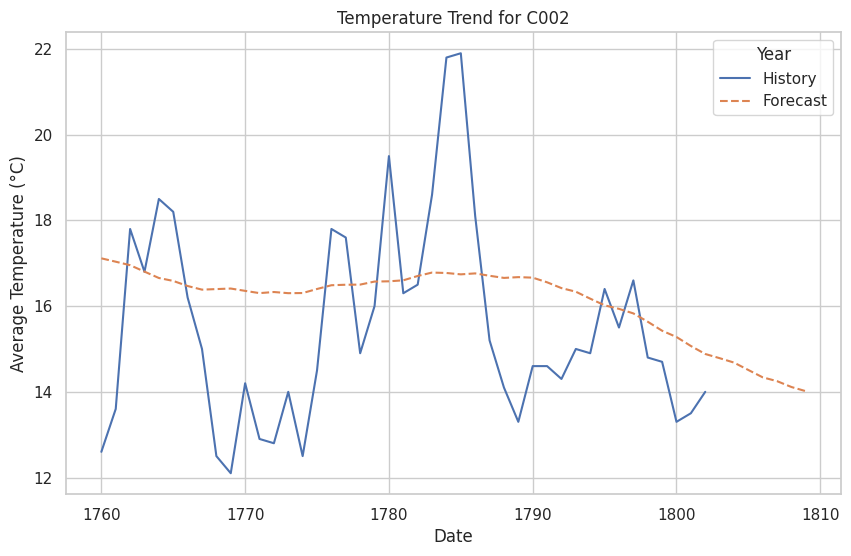

13:03:34 - cmdstanpy - INFO - Chain [1] start processing
13:03:34 - cmdstanpy - INFO - Chain [1] done processing
13:03:35 - cmdstanpy - INFO - Chain [1] start processing
13:03:35 - cmdstanpy - INFO - Chain [1] done processing
13:03:36 - cmdstanpy - INFO - Chain [1] start processing
13:03:37 - cmdstanpy - INFO - Chain [1] done processing


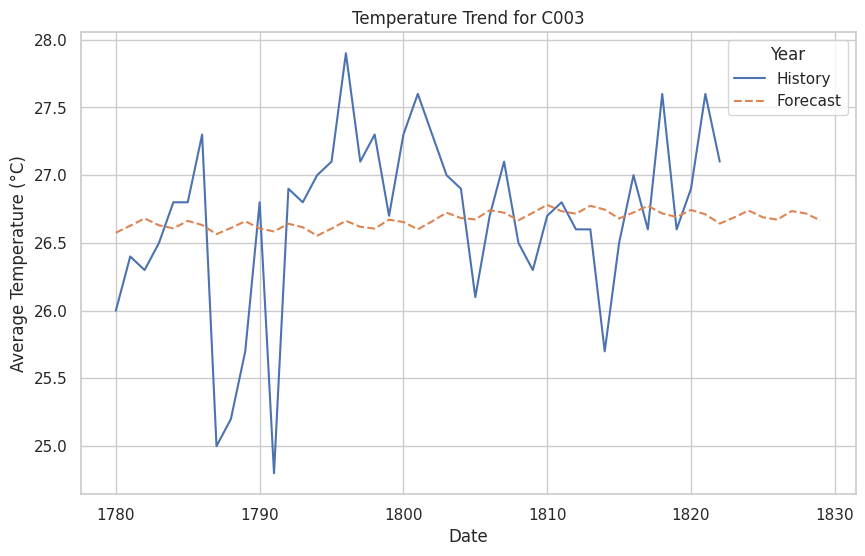

13:03:40 - cmdstanpy - INFO - Chain [1] start processing
13:03:40 - cmdstanpy - INFO - Chain [1] done processing
13:03:40 - cmdstanpy - INFO - Chain [1] start processing
13:03:40 - cmdstanpy - INFO - Chain [1] done processing
13:03:41 - cmdstanpy - INFO - Chain [1] start processing
13:03:41 - cmdstanpy - INFO - Chain [1] done processing


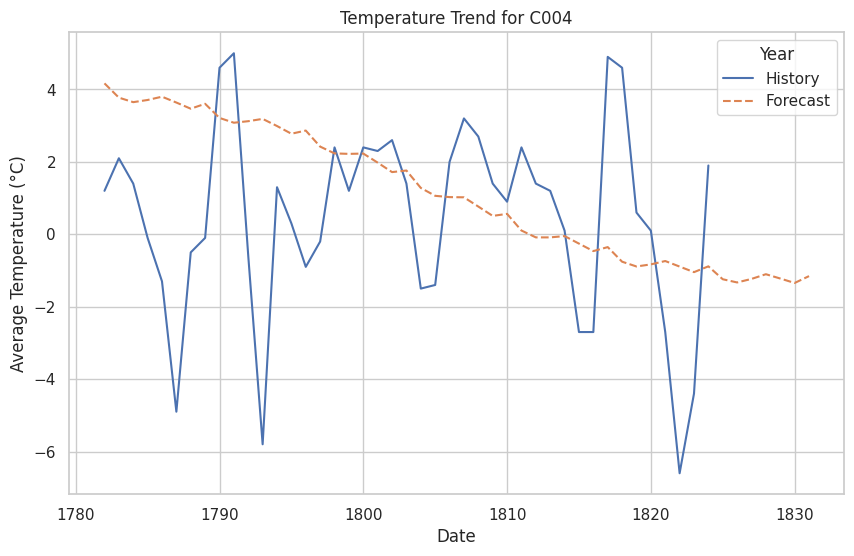

13:03:44 - cmdstanpy - INFO - Chain [1] start processing
13:03:44 - cmdstanpy - INFO - Chain [1] done processing
13:03:44 - cmdstanpy - INFO - Chain [1] start processing
13:03:44 - cmdstanpy - INFO - Chain [1] done processing
13:03:45 - cmdstanpy - INFO - Chain [1] start processing
13:03:46 - cmdstanpy - INFO - Chain [1] done processing


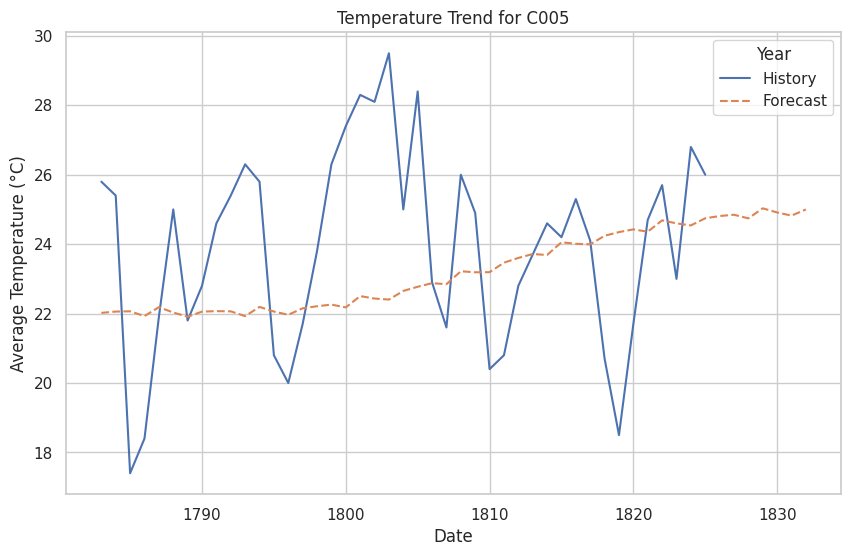

In [27]:
from prophet import Prophet

def forecast_future_with_prophet_regressors(city_data1,col):
    city_data1 = city_data1.sort_values(by='date')
    
    # Prepare data for Prophet
    city_data1 = city_data1.rename(columns={'date': 'ds', col: 'y'})
    
    # Initialize and fit the Prophet model
    model1 = Prophet()
    
    model1.fit(city_data1[['ds', 'y']])
    
    # Create a DataFrame for future dates
    future_dates1 = model1.make_future_dataframe(periods=7)
    
    # Predict future values
    forecast1 = model1.predict(future_dates1)
    
    return forecast1.set_index('ds')['yhat']

# Function to forecast future 7 days using Prophet
def forecast_future_with_prophet(city_data):
    city_fu = city_data.copy()
    city_data = city_data.sort_values(by='date')
    
    # Prepare data for Prophet
    city_data = city_data.rename(columns={'date': 'ds', 'avg_temp_c': 'y'})
    
    # Initialize and fit the Prophet model
    model = Prophet()
    
    # Fit the model with the additional regressor
    model.add_regressor('moving_avg_temp')
    
    model.fit(city_data[['ds', 'y','moving_avg_temp']])
    
    # Create a DataFrame for future dates
    future_dates = model.make_future_dataframe(periods=7)
    #future_dates['moving_avg_temp'] = forecast_future_with_prophet_regressors(city_fu,'moving_avg_temp')
    y =forecast_future_with_prophet_regressors(city_fu,'moving_avg_temp')
    y.name = 'moving_avg_temp'
    
    # Predict moving average temperature for future dates
    y = forecast_future_with_prophet_regressors(city_fu, 'moving_avg_temp')
    y.name = 'moving_avg_temp'
    
    # Combine future dates with predicted moving average temperature
    future_dates = future_dates.set_index('ds')
    future_dates = future_dates.join(y, how='left')
    
    # Check for and handle NaN values in future_dates['moving_avg_temp']
    if future_dates['moving_avg_temp'].isna().sum() > 0:
        print("NaNs found in 'moving_avg_temp'. Please ensure the future moving average temperatures are correctly provided.")
        future_dates['moving_avg_temp'].fillna(method='ffill', inplace=True)  # or handle appropriately
    
    # Predict future values
    forecast = model.predict(future_dates.reset_index())
    
    return forecast.set_index('ds')['yhat']

sns.set(style="whitegrid")

start = '12-31'
end = '01-07'

new_df2=new_df1.copy()

display='avg_temp_c'

cities = new_df2['city_id'].unique()
for city in cities[:5]:
    plt.figure(figsize=(10, 6))
    city_data = new_df2[new_df2['city_id'] == city]
    
    y_forecast = forecast_future_with_prophet(city_data)
    
    # Plot data for each year in a different color
    
    yearly_data = city_data.copy()
    
    
    for i in range(7):
        yearly_data.loc[len(yearly_data)] = [np.nan] * yearly_data.shape[1]
    yearly_data['index'] = np.arange(len(yearly_data.index))
    pl = yearly_data[-50:]
    plt.plot(pl['index'], pl[display], label='History')
    plt.plot(pl['index'], y_forecast[-50:], label='Forecast', linestyle='dashed')
    
    plt.title(f'Temperature Trend for {city}')
    plt.xlabel('Date')
    plt.ylabel('Average Temperature (°C)')
    plt.legend(title='Year')
    plt.show()


## Only for January

13:04:02 - cmdstanpy - INFO - Chain [1] start processing
13:04:02 - cmdstanpy - INFO - Chain [1] done processing


ds
2019-01-01    8.155202
2019-01-02    7.815112
2019-01-03    7.459024
2019-01-04    7.112249
2019-01-05    6.914884
2019-01-06    7.028058
2019-01-07    7.094033
Name: yhat, dtype: float64


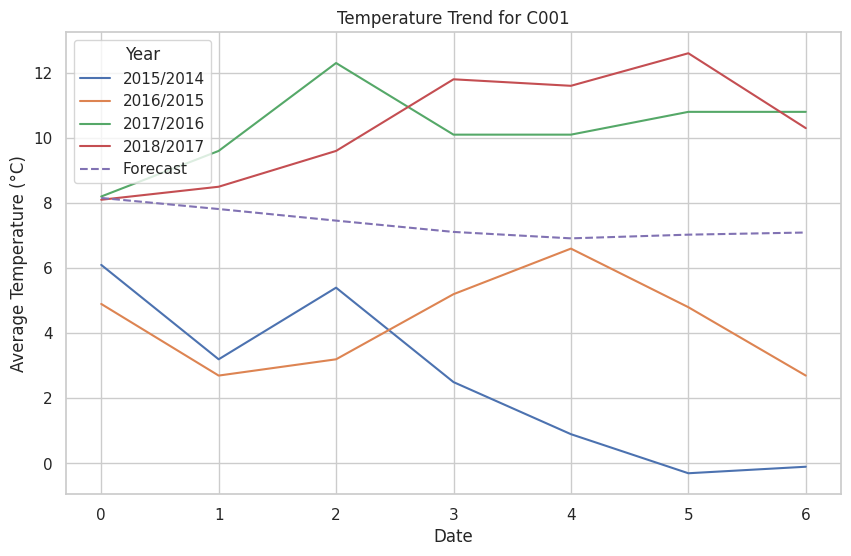

13:04:04 - cmdstanpy - INFO - Chain [1] start processing
13:04:04 - cmdstanpy - INFO - Chain [1] done processing


ds
2019-01-01    14.627174
2019-01-02    14.521557
2019-01-03    14.346999
2019-01-04    14.173330
2019-01-05    14.082224
2019-01-06    13.943684
2019-01-07    13.844206
Name: yhat, dtype: float64


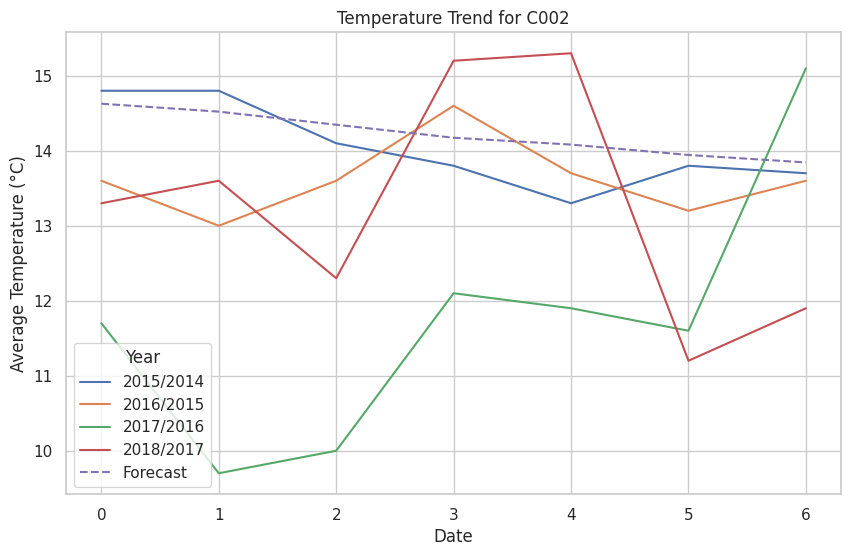

13:04:05 - cmdstanpy - INFO - Chain [1] start processing
13:04:06 - cmdstanpy - INFO - Chain [1] done processing


ds
2019-01-01    26.741667
2019-01-02    26.793334
2019-01-03    26.743687
2019-01-04    26.726553
2019-01-05    26.790479
2019-01-06    26.772700
2019-01-07    26.721662
Name: yhat, dtype: float64


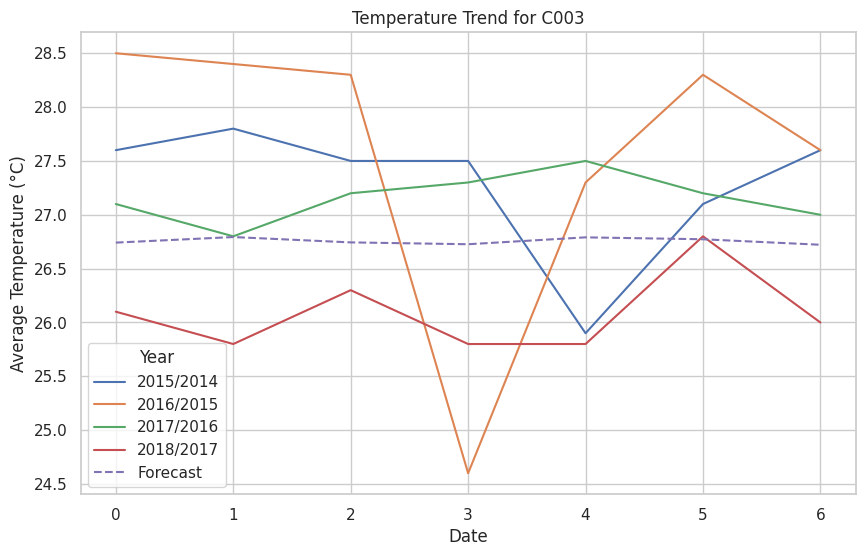

13:04:08 - cmdstanpy - INFO - Chain [1] start processing
13:04:08 - cmdstanpy - INFO - Chain [1] done processing


ds
2019-01-01   -1.327616
2019-01-02   -1.407088
2019-01-03   -1.302350
2019-01-04   -1.165511
2019-01-05   -1.278132
2019-01-06   -1.394492
2019-01-07   -1.199415
Name: yhat, dtype: float64


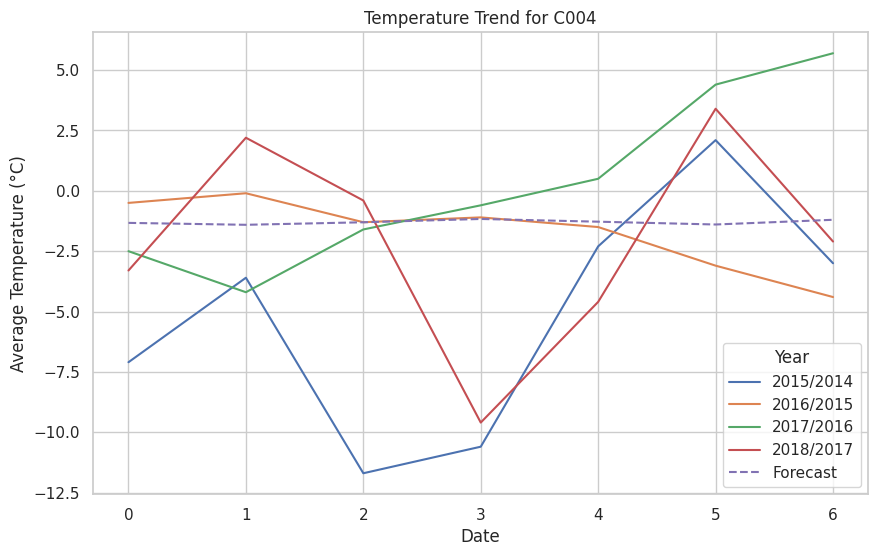

13:04:10 - cmdstanpy - INFO - Chain [1] start processing
13:04:10 - cmdstanpy - INFO - Chain [1] done processing


ds
2019-01-01    24.649508
2019-01-02    24.687562
2019-01-03    24.582771
2019-01-04    24.872371
2019-01-05    24.752108
2019-01-06    24.661362
2019-01-07    24.837543
Name: yhat, dtype: float64


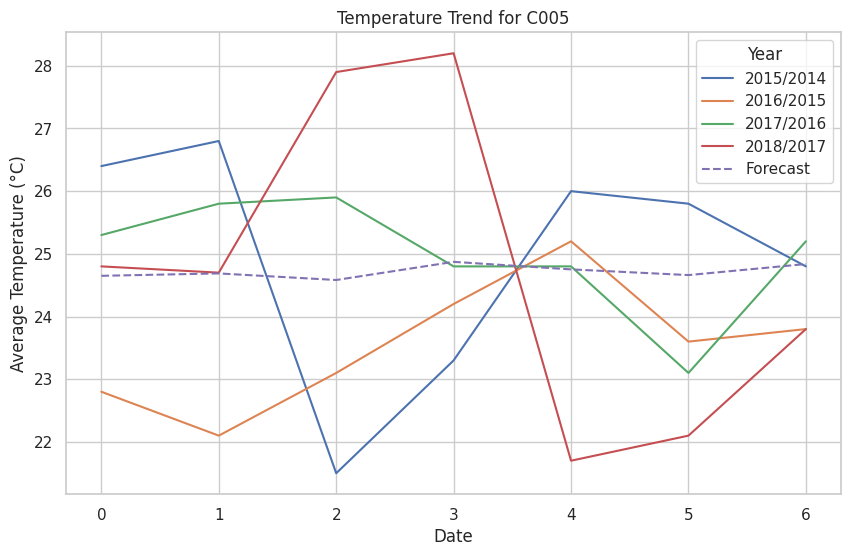

In [28]:
from prophet import Prophet
# Function to forecast future 7 days using Prophet
def forecast_future_with_prophet(city_data):
    city_data = city_data.sort_values(by='date')
    
    # Prepare data for Prophet
    city_data = city_data.rename(columns={'date': 'ds', 'avg_temp_c': 'y'})
    
    # Initialize and fit the Prophet model
    model = Prophet()
    model.fit(city_data[['ds', 'y']])
    
    # Create a DataFrame for future dates
    future_dates = model.make_future_dataframe(periods=7)
    
    # Predict future values
    forecast = model.predict(future_dates)
    
    return forecast.set_index('ds')['yhat']

sns.set(style="whitegrid")

start = '12-31'
end = '01-07'

new_df2=new_df1.copy()

display='avg_temp_c'

cities = new_df2['city_id'].unique()
for city in cities[:5]:
    plt.figure(figsize=(10, 6))
    city_data = new_df2[new_df2['city_id'] == city]
    
    y_forecast = forecast_future_with_prophet(city_data)
    
    # Plot data for each year in a different color
    
    yearly_data = city_data[(city_data['date'] <='2015-'+end) & (city_data['date'] > '2014-'+start)]
    yearly_data['index'] = np.arange(len(yearly_data.index))
    plt.plot(yearly_data['index'], yearly_data[display], label='2015/2014')
    
    yearly_data = city_data[(city_data['date'] <='2016-'+end) & (city_data['date'] > '2015-'+start)]
    yearly_data['index'] = np.arange(len(yearly_data.index))
    plt.plot(yearly_data['index'], yearly_data[display], label='2016/2015')
    
    yearly_data = city_data[(city_data['date'] <='2017-'+end) & (city_data['date'] > '2016-'+start)]
    yearly_data['index'] = np.arange(len(yearly_data.index))
    plt.plot(yearly_data['index'], yearly_data[display], label='2017/2016')
    
    yearly_data = city_data[(city_data['date'] <='2018-'+end) & (city_data['date'] > '2017-'+start)]
    yearly_data['index'] = np.arange(len(yearly_data.index))
    plt.plot(yearly_data['index'], yearly_data[display], label='2018/2017')
    
    
    print(y_forecast[-7:])
    plt.plot(yearly_data['index'], y_forecast[-7:], label='Forecast', linestyle='dashed')
    
    plt.title(f'Temperature Trend for {city}')
    plt.xlabel('Date')
    plt.ylabel('Average Temperature (°C)')
    plt.legend(title='Year')
    plt.show()

# Prediction Saving

## Without Regressors

In [29]:
final_data = pd.read_csv('/kaggle/input/predicta-1-0-predict-the-unpredictable/submission_key.csv')
final_data['date'] = pd.to_datetime(final_data['date'])
final_data['avg_temp_c'] = np.nan 

final_data.head()

,submission_ID,city_id,date,avg_temp_c
0,1,C001,2019-01-01,NaN
1,2,C001,2019-01-02,NaN
2,3,C001,2019-01-03,NaN
3,4,C001,2019-01-04,NaN
4,5,C001,2019-01-05,NaN


# Without Regressors (Not Much Accurate)

In [30]:
#Without Regressor
import warnings
warnings.filterwarnings("ignore")

from prophet import Prophet

def forecast_future_with_prophet_regressors(city_data1,col):
    city_data1 = city_data1.sort_values(by='date')
    
    # Prepare data for Prophet
    city_data1 = city_data1.rename(columns={'date': 'ds', col: 'y'})
    
    # Initialize and fit the Prophet model
    model1 = Prophet()
    
    model1.fit(city_data1[['ds', 'y']])
    
    # Create a DataFrame for future dates
    future_dates1 = model1.make_future_dataframe(periods=7)
    
    # Predict future values
    forecast1 = model1.predict(future_dates1)
    
    return forecast1.set_index('ds')['yhat']

# Function to forecast future 7 days using Prophet
def forecast_future_with_prophet(city_data):
    city_fu = city_data.copy()
    city_data = city_data.sort_values(by='date')
    
    # Prepare data for Prophet
    city_data = city_data.rename(columns={'date': 'ds', 'avg_temp_c': 'y'})
    
    # Initialize and fit the Prophet model
    model = Prophet()
    
    model.fit(city_data[['ds', 'y']])
    
    # Create a DataFrame for future dates
    future_dates = model.make_future_dataframe(periods=7)
    
    # Predict future values
    forecast = model.predict(future_dates)
    
    return forecast.set_index('ds')['yhat']


start_date = '2019-01-01'
end_date = '2019-01-07'

new_df2=new_df1.copy()

display='avg_temp_c'

final_data2 = pd.read_csv(test_file_path)
final_data2['avg_temp_c'] = np.nan
final_data2['date'] = pd.to_datetime(final_data2['date'])

cities = new_df2['city_id'].unique()
for city in cities:
    city_data = new_df2[new_df2['city_id'] == city]
    
    y_forecast = forecast_future_with_prophet(city_data)
    print(city)    
    
    # Update the avg_temp for the specified city_id and date range
    final_data2.loc[(final_data2['city_id'] == city) & (final_data2['date'] >= start_date) & (final_data2['date'] <= end_date), 'avg_temp_c'] = y_forecast[-7:].values
final_data2[:16]

13:04:22 - cmdstanpy - INFO - Chain [1] start processing
13:04:22 - cmdstanpy - INFO - Chain [1] done processing
13:04:23 - cmdstanpy - INFO - Chain [1] start processing


C001


13:04:23 - cmdstanpy - INFO - Chain [1] done processing
13:04:24 - cmdstanpy - INFO - Chain [1] start processing


C002


13:04:25 - cmdstanpy - INFO - Chain [1] done processing
13:04:26 - cmdstanpy - INFO - Chain [1] start processing


C003


13:04:26 - cmdstanpy - INFO - Chain [1] done processing
13:04:27 - cmdstanpy - INFO - Chain [1] start processing


C004


13:04:27 - cmdstanpy - INFO - Chain [1] done processing
13:04:28 - cmdstanpy - INFO - Chain [1] start processing


C005


13:04:28 - cmdstanpy - INFO - Chain [1] done processing
13:04:29 - cmdstanpy - INFO - Chain [1] start processing


C007


13:04:30 - cmdstanpy - INFO - Chain [1] done processing
13:04:31 - cmdstanpy - INFO - Chain [1] start processing


C008


13:04:31 - cmdstanpy - INFO - Chain [1] done processing
13:04:32 - cmdstanpy - INFO - Chain [1] start processing


C009


13:04:32 - cmdstanpy - INFO - Chain [1] done processing
13:04:33 - cmdstanpy - INFO - Chain [1] start processing


C010


13:04:33 - cmdstanpy - INFO - Chain [1] done processing
13:04:34 - cmdstanpy - INFO - Chain [1] start processing


C011


13:04:35 - cmdstanpy - INFO - Chain [1] done processing
13:04:36 - cmdstanpy - INFO - Chain [1] start processing


C012


13:04:36 - cmdstanpy - INFO - Chain [1] done processing
13:04:37 - cmdstanpy - INFO - Chain [1] start processing


C013


13:04:37 - cmdstanpy - INFO - Chain [1] done processing
13:04:38 - cmdstanpy - INFO - Chain [1] start processing


C014


13:04:38 - cmdstanpy - INFO - Chain [1] done processing
13:04:39 - cmdstanpy - INFO - Chain [1] start processing


C015


13:04:40 - cmdstanpy - INFO - Chain [1] done processing
13:04:40 - cmdstanpy - INFO - Chain [1] start processing


C016


13:04:41 - cmdstanpy - INFO - Chain [1] done processing
13:04:42 - cmdstanpy - INFO - Chain [1] start processing


C017


13:04:42 - cmdstanpy - INFO - Chain [1] done processing
13:04:43 - cmdstanpy - INFO - Chain [1] start processing


C018


13:04:44 - cmdstanpy - INFO - Chain [1] done processing
13:04:44 - cmdstanpy - INFO - Chain [1] start processing


C020


13:04:45 - cmdstanpy - INFO - Chain [1] done processing
13:04:46 - cmdstanpy - INFO - Chain [1] start processing


C022


13:04:46 - cmdstanpy - INFO - Chain [1] done processing
13:04:47 - cmdstanpy - INFO - Chain [1] start processing


C023


13:04:47 - cmdstanpy - INFO - Chain [1] done processing
13:04:48 - cmdstanpy - INFO - Chain [1] start processing


C024


13:04:48 - cmdstanpy - INFO - Chain [1] done processing
13:04:49 - cmdstanpy - INFO - Chain [1] start processing


C025


13:04:49 - cmdstanpy - INFO - Chain [1] done processing
13:04:50 - cmdstanpy - INFO - Chain [1] start processing


C027


13:04:51 - cmdstanpy - INFO - Chain [1] done processing
13:04:52 - cmdstanpy - INFO - Chain [1] start processing


C028


13:04:52 - cmdstanpy - INFO - Chain [1] done processing
13:04:53 - cmdstanpy - INFO - Chain [1] start processing


C029


13:04:54 - cmdstanpy - INFO - Chain [1] done processing
13:04:55 - cmdstanpy - INFO - Chain [1] start processing


C030


13:04:55 - cmdstanpy - INFO - Chain [1] done processing
13:04:56 - cmdstanpy - INFO - Chain [1] start processing


C031


13:04:56 - cmdstanpy - INFO - Chain [1] done processing
13:04:57 - cmdstanpy - INFO - Chain [1] start processing


C033


13:04:57 - cmdstanpy - INFO - Chain [1] done processing
13:04:58 - cmdstanpy - INFO - Chain [1] start processing


C034


13:04:58 - cmdstanpy - INFO - Chain [1] done processing
13:04:59 - cmdstanpy - INFO - Chain [1] start processing


C035


13:05:00 - cmdstanpy - INFO - Chain [1] done processing
13:05:01 - cmdstanpy - INFO - Chain [1] start processing


C036


13:05:01 - cmdstanpy - INFO - Chain [1] done processing
13:05:02 - cmdstanpy - INFO - Chain [1] start processing


C037


13:05:02 - cmdstanpy - INFO - Chain [1] done processing
13:05:03 - cmdstanpy - INFO - Chain [1] start processing


C038


13:05:04 - cmdstanpy - INFO - Chain [1] done processing
13:05:05 - cmdstanpy - INFO - Chain [1] start processing


C039


13:05:05 - cmdstanpy - INFO - Chain [1] done processing
13:05:06 - cmdstanpy - INFO - Chain [1] start processing


C040


13:05:07 - cmdstanpy - INFO - Chain [1] done processing
13:05:07 - cmdstanpy - INFO - Chain [1] start processing


C042


13:05:08 - cmdstanpy - INFO - Chain [1] done processing
13:05:09 - cmdstanpy - INFO - Chain [1] start processing


C043


13:05:09 - cmdstanpy - INFO - Chain [1] done processing
13:05:10 - cmdstanpy - INFO - Chain [1] start processing


C044


13:05:11 - cmdstanpy - INFO - Chain [1] done processing
13:05:11 - cmdstanpy - INFO - Chain [1] start processing


C045


13:05:12 - cmdstanpy - INFO - Chain [1] done processing
13:05:13 - cmdstanpy - INFO - Chain [1] start processing


C046


13:05:13 - cmdstanpy - INFO - Chain [1] done processing
13:05:14 - cmdstanpy - INFO - Chain [1] start processing


C047


13:05:14 - cmdstanpy - INFO - Chain [1] done processing
13:05:15 - cmdstanpy - INFO - Chain [1] start processing


C048


13:05:15 - cmdstanpy - INFO - Chain [1] done processing
13:05:16 - cmdstanpy - INFO - Chain [1] start processing


C049


13:05:17 - cmdstanpy - INFO - Chain [1] done processing
13:05:18 - cmdstanpy - INFO - Chain [1] start processing


C051


13:05:18 - cmdstanpy - INFO - Chain [1] done processing
13:05:19 - cmdstanpy - INFO - Chain [1] start processing


C053


13:05:19 - cmdstanpy - INFO - Chain [1] done processing
13:05:20 - cmdstanpy - INFO - Chain [1] start processing


C054


13:05:21 - cmdstanpy - INFO - Chain [1] done processing
13:05:22 - cmdstanpy - INFO - Chain [1] start processing


C055


13:05:22 - cmdstanpy - INFO - Chain [1] done processing
13:05:23 - cmdstanpy - INFO - Chain [1] start processing


C056


13:05:23 - cmdstanpy - INFO - Chain [1] done processing
13:05:24 - cmdstanpy - INFO - Chain [1] start processing


C057


13:05:25 - cmdstanpy - INFO - Chain [1] done processing
13:05:26 - cmdstanpy - INFO - Chain [1] start processing


C058


13:05:26 - cmdstanpy - INFO - Chain [1] done processing
13:05:27 - cmdstanpy - INFO - Chain [1] start processing


C059


13:05:27 - cmdstanpy - INFO - Chain [1] done processing
13:05:28 - cmdstanpy - INFO - Chain [1] start processing


C061


13:05:29 - cmdstanpy - INFO - Chain [1] done processing
13:05:30 - cmdstanpy - INFO - Chain [1] start processing


C062


13:05:30 - cmdstanpy - INFO - Chain [1] done processing
13:05:31 - cmdstanpy - INFO - Chain [1] start processing


C064


13:05:31 - cmdstanpy - INFO - Chain [1] done processing
13:05:32 - cmdstanpy - INFO - Chain [1] start processing


C065


13:05:32 - cmdstanpy - INFO - Chain [1] done processing
13:05:33 - cmdstanpy - INFO - Chain [1] start processing


C066


13:05:34 - cmdstanpy - INFO - Chain [1] done processing
13:05:35 - cmdstanpy - INFO - Chain [1] start processing


C067


13:05:35 - cmdstanpy - INFO - Chain [1] done processing
13:05:36 - cmdstanpy - INFO - Chain [1] start processing


C068


13:05:36 - cmdstanpy - INFO - Chain [1] done processing
13:05:37 - cmdstanpy - INFO - Chain [1] start processing


C069


13:05:37 - cmdstanpy - INFO - Chain [1] done processing
13:05:38 - cmdstanpy - INFO - Chain [1] start processing


C070


13:05:39 - cmdstanpy - INFO - Chain [1] done processing


C071


13:05:40 - cmdstanpy - INFO - Chain [1] start processing
13:05:40 - cmdstanpy - INFO - Chain [1] done processing
13:05:41 - cmdstanpy - INFO - Chain [1] start processing


C072


13:05:41 - cmdstanpy - INFO - Chain [1] done processing
13:05:42 - cmdstanpy - INFO - Chain [1] start processing


C073


13:05:42 - cmdstanpy - INFO - Chain [1] done processing
13:05:43 - cmdstanpy - INFO - Chain [1] start processing


C074


13:05:43 - cmdstanpy - INFO - Chain [1] done processing
13:05:44 - cmdstanpy - INFO - Chain [1] start processing


C076


13:05:44 - cmdstanpy - INFO - Chain [1] done processing
13:05:45 - cmdstanpy - INFO - Chain [1] start processing


C077


13:05:46 - cmdstanpy - INFO - Chain [1] done processing
13:05:47 - cmdstanpy - INFO - Chain [1] start processing


C078


13:05:47 - cmdstanpy - INFO - Chain [1] done processing
13:05:48 - cmdstanpy - INFO - Chain [1] start processing


C079


13:05:48 - cmdstanpy - INFO - Chain [1] done processing
13:05:49 - cmdstanpy - INFO - Chain [1] start processing


C081


13:05:50 - cmdstanpy - INFO - Chain [1] done processing
13:05:51 - cmdstanpy - INFO - Chain [1] start processing


C082


13:05:51 - cmdstanpy - INFO - Chain [1] done processing
13:05:52 - cmdstanpy - INFO - Chain [1] start processing


C083


13:05:52 - cmdstanpy - INFO - Chain [1] done processing
13:05:53 - cmdstanpy - INFO - Chain [1] start processing


C084


13:05:53 - cmdstanpy - INFO - Chain [1] done processing
13:05:54 - cmdstanpy - INFO - Chain [1] start processing


C085


13:05:54 - cmdstanpy - INFO - Chain [1] done processing
13:05:55 - cmdstanpy - INFO - Chain [1] start processing


C086


13:05:56 - cmdstanpy - INFO - Chain [1] done processing
13:05:57 - cmdstanpy - INFO - Chain [1] start processing


C087


13:05:57 - cmdstanpy - INFO - Chain [1] done processing
13:05:58 - cmdstanpy - INFO - Chain [1] start processing


C088


13:05:58 - cmdstanpy - INFO - Chain [1] done processing


C089


13:05:59 - cmdstanpy - INFO - Chain [1] start processing
13:05:59 - cmdstanpy - INFO - Chain [1] done processing
13:06:00 - cmdstanpy - INFO - Chain [1] start processing


C090


13:06:00 - cmdstanpy - INFO - Chain [1] done processing
13:06:01 - cmdstanpy - INFO - Chain [1] start processing


C091


13:06:02 - cmdstanpy - INFO - Chain [1] done processing
13:06:03 - cmdstanpy - INFO - Chain [1] start processing


C092


13:06:03 - cmdstanpy - INFO - Chain [1] done processing
13:06:04 - cmdstanpy - INFO - Chain [1] start processing


C093


13:06:04 - cmdstanpy - INFO - Chain [1] done processing
13:06:05 - cmdstanpy - INFO - Chain [1] start processing


C094


13:06:05 - cmdstanpy - INFO - Chain [1] done processing
13:06:06 - cmdstanpy - INFO - Chain [1] start processing


C095


13:06:06 - cmdstanpy - INFO - Chain [1] done processing
13:06:07 - cmdstanpy - INFO - Chain [1] start processing


C096


13:06:07 - cmdstanpy - INFO - Chain [1] done processing
13:06:08 - cmdstanpy - INFO - Chain [1] start processing


C097


13:06:09 - cmdstanpy - INFO - Chain [1] done processing
13:06:10 - cmdstanpy - INFO - Chain [1] start processing


C098


13:06:10 - cmdstanpy - INFO - Chain [1] done processing
13:06:11 - cmdstanpy - INFO - Chain [1] start processing


C099


13:06:11 - cmdstanpy - INFO - Chain [1] done processing
13:06:12 - cmdstanpy - INFO - Chain [1] start processing


C100


13:06:13 - cmdstanpy - INFO - Chain [1] done processing
13:06:14 - cmdstanpy - INFO - Chain [1] start processing


C101


13:06:14 - cmdstanpy - INFO - Chain [1] done processing
13:06:15 - cmdstanpy - INFO - Chain [1] start processing


C102


13:06:15 - cmdstanpy - INFO - Chain [1] done processing
13:06:16 - cmdstanpy - INFO - Chain [1] start processing


C103


13:06:16 - cmdstanpy - INFO - Chain [1] done processing
13:06:17 - cmdstanpy - INFO - Chain [1] start processing


C104


13:06:17 - cmdstanpy - INFO - Chain [1] done processing


C105


13:06:18 - cmdstanpy - INFO - Chain [1] start processing
13:06:19 - cmdstanpy - INFO - Chain [1] done processing
13:06:20 - cmdstanpy - INFO - Chain [1] start processing


C106


13:06:20 - cmdstanpy - INFO - Chain [1] done processing
13:06:21 - cmdstanpy - INFO - Chain [1] start processing


C107


13:06:21 - cmdstanpy - INFO - Chain [1] done processing
13:06:22 - cmdstanpy - INFO - Chain [1] start processing


C108


13:06:22 - cmdstanpy - INFO - Chain [1] done processing
13:06:23 - cmdstanpy - INFO - Chain [1] start processing


C109


13:06:23 - cmdstanpy - INFO - Chain [1] done processing
13:06:24 - cmdstanpy - INFO - Chain [1] start processing


C110


13:06:24 - cmdstanpy - INFO - Chain [1] done processing
13:06:25 - cmdstanpy - INFO - Chain [1] start processing


C111


13:06:26 - cmdstanpy - INFO - Chain [1] done processing


C112


,submission_ID,city_id,date,avg_temp_c
0,1,C001,2019-01-01,8.155202
1,2,C001,2019-01-02,7.815112
2,3,C001,2019-01-03,7.459024
3,4,C001,2019-01-04,7.112249
4,5,C001,2019-01-05,6.914884
5,6,C001,2019-01-06,7.028058
6,7,C001,2019-01-07,7.094033
7,8,C002,2019-01-01,14.627174
8,9,C002,2019-01-02,14.521557
9,10,C002,2019-01-03,14.346999


In [ ]:
output2 = final_data.drop(columns=['city_id','date'],axis=1)
output2.to_csv('SecSub_day3.csv',index=False)

In [31]:
new_df1.head()

,city_id,date,avg_temp_c,day,month,year,C001,C002,C003,C004,...,C107,C108,C109,C110,C111,C112,city_avg_temp_for_month,city_avg_max_temp_for_month,city_avg_min_temp_for_month,moving_avg_temp
0,C001,2014-01-01,6.6,1,1,2014,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,7.558065,12.0,2.8,7.775000
1,C001,2014-01-02,9.3,2,1,2014,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,7.558065,12.0,2.8,7.940000
2,C001,2014-01-03,7.6,3,1,2014,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,7.558065,12.0,2.8,8.133333
3,C001,2014-01-04,7.6,4,1,2014,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,7.558065,12.0,2.8,8.228571
4,C001,2014-01-05,8.6,5,1,2014,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,7.558065,12.0,2.8,8.542857


# With Regressors

In [32]:
final_data3 = pd.read_csv('/kaggle/input/predicta-1-0-predict-the-unpredictable/submission_key.csv')
final_data3['date'] = pd.to_datetime(final_data3['date'])
final_data3['avg_temp_c'] = np.nan 

final_data3.head()

,submission_ID,city_id,date,avg_temp_c
0,1,C001,2019-01-01,NaN
1,2,C001,2019-01-02,NaN
2,3,C001,2019-01-03,NaN
3,4,C001,2019-01-04,NaN
4,5,C001,2019-01-05,NaN


# With Regressors (Moving Average)

* We tried with other features using as regressors, but the best accuracy scored by **only with the moving average as a regressor**

In [33]:
from prophet import Prophet

def forecast_future_with_prophet_regressors(city_data1,col):
    city_data1 = city_data1.sort_values(by='date')
    
    # Prepare data for Prophet
    city_data1 = city_data1.rename(columns={'date': 'ds', col: 'y'})
    
    # Initialize and fit the Prophet model
    model1 = Prophet()
    
    model1.fit(city_data1[['ds', 'y']])
    
    # Create a DataFrame for future dates
    future_dates1 = model1.make_future_dataframe(periods=7)
    
    # Predict future values
    forecast1 = model1.predict(future_dates1)
    
    return forecast1.set_index('ds')['yhat']

# Function to forecast future 7 days using Prophet
def forecast_future_with_prophet(city_data):
    city_fu = city_data.copy()
    city_data = city_data.sort_values(by='date')
    
    # Prepare data for Prophet
    city_data = city_data.rename(columns={'date': 'ds', 'avg_temp_c': 'y'})
    
    # Initialize and fit the Prophet model
    model = Prophet()
    
    # Fit the model with the additional regressor
    model.add_regressor('moving_avg_temp')
    #model.add_regressor('city_avg_temp_for_month')
    
    model.fit(city_data[['ds', 'y','moving_avg_temp']])
    
    # Create a DataFrame for future dates
    future_dates = model.make_future_dataframe(periods=7)
    #future_dates['moving_avg_temp'] = forecast_future_with_prophet_regressors(city_fu,'moving_avg_temp')
    y =forecast_future_with_prophet_regressors(city_fu,'moving_avg_temp')
    y.name = 'moving_avg_temp'
    
    # Combine future dates with predicted moving average temperature
    future_dates = future_dates.set_index('ds')
    future_dates = future_dates.join(y, how='left')
    
    # Check for and handle NaN values in future_dates['moving_avg_temp']
    if future_dates['moving_avg_temp'].isna().sum() > 0:
        print("NaNs found in 'moving_avg_temp'. Please ensure the future moving average temperatures are correctly provided.")
        future_dates['moving_avg_temp'].fillna(method='ffill', inplace=True)  # or handle appropriately
    
    
    #Code for testing with other features as regressors ; --Failed
    
    # Predict city_avg_temp_for_month for future dates
    #y = forecast_future_with_prophet_regressors(city_fu, 'city_avg_temp_for_month')
    #y.name = 'city_avg_temp_for_month'
    
    # Combine future dates with predicted city_avg_temp_for_month
    #future_dates = future_dates.join(y, how='left')
    
    # Check for and handle NaN values in future_dates['city_avg_temp_for_month']
    #if future_dates['city_avg_temp_for_month'].isna().sum() > 0:
    #    print("NaNs found in 'city_avg_temp_for_month'. Please ensure the future city_avg_temp_for_month are correctly provided.")
    #    future_dates['city_avg_temp_for_month'].fillna(method='ffill', inplace=True)  # or handle appropriately
    
    
    # Predict future values
    forecast = model.predict(future_dates.reset_index())
    
    return forecast.set_index('ds')['yhat']


start_date = '2019-01-01'
end_date = '2019-01-07'

new_df2=new_df1.copy()

cities = new_df2['city_id'].unique()
for city in cities:
    city_data = new_df2[new_df2['city_id'] == city]
    
    y_forecast = forecast_future_with_prophet(city_data)
    print(city)
    
    # Update the avg_temp for the specified city_id and date range
    final_data3.loc[(final_data3['city_id'] == city) & (final_data3['date'] >= start_date) & (final_data3['date'] <= end_date), 'avg_temp_c'] = y_forecast[-7:].values
final_data3[:8]



13:10:44 - cmdstanpy - INFO - Chain [1] start processing
13:10:44 - cmdstanpy - INFO - Chain [1] done processing
13:10:44 - cmdstanpy - INFO - Chain [1] start processing
13:10:44 - cmdstanpy - INFO - Chain [1] done processing
13:10:46 - cmdstanpy - INFO - Chain [1] start processing


C001


13:10:46 - cmdstanpy - INFO - Chain [1] done processing
13:10:47 - cmdstanpy - INFO - Chain [1] start processing
13:10:47 - cmdstanpy - INFO - Chain [1] done processing
13:10:48 - cmdstanpy - INFO - Chain [1] start processing


C002


13:10:49 - cmdstanpy - INFO - Chain [1] done processing
13:10:49 - cmdstanpy - INFO - Chain [1] start processing
13:10:50 - cmdstanpy - INFO - Chain [1] done processing
13:10:52 - cmdstanpy - INFO - Chain [1] start processing


C003


13:10:52 - cmdstanpy - INFO - Chain [1] done processing
13:10:52 - cmdstanpy - INFO - Chain [1] start processing
13:10:52 - cmdstanpy - INFO - Chain [1] done processing
13:10:54 - cmdstanpy - INFO - Chain [1] start processing


C004


13:10:54 - cmdstanpy - INFO - Chain [1] done processing
13:10:54 - cmdstanpy - INFO - Chain [1] start processing
13:10:54 - cmdstanpy - INFO - Chain [1] done processing
13:10:56 - cmdstanpy - INFO - Chain [1] start processing


C005


13:10:56 - cmdstanpy - INFO - Chain [1] done processing
13:10:56 - cmdstanpy - INFO - Chain [1] start processing
13:10:57 - cmdstanpy - INFO - Chain [1] done processing


C007


13:10:58 - cmdstanpy - INFO - Chain [1] start processing
13:10:59 - cmdstanpy - INFO - Chain [1] done processing
13:10:59 - cmdstanpy - INFO - Chain [1] start processing
13:10:59 - cmdstanpy - INFO - Chain [1] done processing
13:11:01 - cmdstanpy - INFO - Chain [1] start processing


C008


13:11:01 - cmdstanpy - INFO - Chain [1] done processing
13:11:01 - cmdstanpy - INFO - Chain [1] start processing
13:11:02 - cmdstanpy - INFO - Chain [1] done processing
13:11:03 - cmdstanpy - INFO - Chain [1] start processing


C009


13:11:03 - cmdstanpy - INFO - Chain [1] done processing
13:11:04 - cmdstanpy - INFO - Chain [1] start processing
13:11:04 - cmdstanpy - INFO - Chain [1] done processing
13:11:06 - cmdstanpy - INFO - Chain [1] start processing


C010


13:11:06 - cmdstanpy - INFO - Chain [1] done processing
13:11:06 - cmdstanpy - INFO - Chain [1] start processing
13:11:06 - cmdstanpy - INFO - Chain [1] done processing
13:11:08 - cmdstanpy - INFO - Chain [1] start processing


C011


13:11:08 - cmdstanpy - INFO - Chain [1] done processing
13:11:08 - cmdstanpy - INFO - Chain [1] start processing
13:11:09 - cmdstanpy - INFO - Chain [1] done processing
13:11:10 - cmdstanpy - INFO - Chain [1] start processing


C012


13:11:10 - cmdstanpy - INFO - Chain [1] done processing
13:11:11 - cmdstanpy - INFO - Chain [1] start processing
13:11:11 - cmdstanpy - INFO - Chain [1] done processing
13:11:12 - cmdstanpy - INFO - Chain [1] start processing


C013


13:11:13 - cmdstanpy - INFO - Chain [1] done processing
13:11:13 - cmdstanpy - INFO - Chain [1] start processing
13:11:13 - cmdstanpy - INFO - Chain [1] done processing
13:11:15 - cmdstanpy - INFO - Chain [1] start processing


C014


13:11:15 - cmdstanpy - INFO - Chain [1] done processing
13:11:15 - cmdstanpy - INFO - Chain [1] start processing
13:11:16 - cmdstanpy - INFO - Chain [1] done processing
13:11:17 - cmdstanpy - INFO - Chain [1] start processing


C015


13:11:17 - cmdstanpy - INFO - Chain [1] done processing
13:11:18 - cmdstanpy - INFO - Chain [1] start processing
13:11:18 - cmdstanpy - INFO - Chain [1] done processing
13:11:20 - cmdstanpy - INFO - Chain [1] start processing


C016


13:11:20 - cmdstanpy - INFO - Chain [1] done processing
13:11:20 - cmdstanpy - INFO - Chain [1] start processing
13:11:21 - cmdstanpy - INFO - Chain [1] done processing
13:11:22 - cmdstanpy - INFO - Chain [1] start processing


C017


13:11:23 - cmdstanpy - INFO - Chain [1] done processing
13:11:23 - cmdstanpy - INFO - Chain [1] start processing
13:11:23 - cmdstanpy - INFO - Chain [1] done processing
13:11:25 - cmdstanpy - INFO - Chain [1] start processing


C018


13:11:25 - cmdstanpy - INFO - Chain [1] done processing
13:11:25 - cmdstanpy - INFO - Chain [1] start processing
13:11:26 - cmdstanpy - INFO - Chain [1] done processing
13:11:27 - cmdstanpy - INFO - Chain [1] start processing


C020


13:11:28 - cmdstanpy - INFO - Chain [1] done processing
13:11:28 - cmdstanpy - INFO - Chain [1] start processing
13:11:28 - cmdstanpy - INFO - Chain [1] done processing
13:11:30 - cmdstanpy - INFO - Chain [1] start processing


C022


13:11:30 - cmdstanpy - INFO - Chain [1] done processing
13:11:30 - cmdstanpy - INFO - Chain [1] start processing
13:11:30 - cmdstanpy - INFO - Chain [1] done processing
13:11:32 - cmdstanpy - INFO - Chain [1] start processing


C023


13:11:32 - cmdstanpy - INFO - Chain [1] done processing
13:11:32 - cmdstanpy - INFO - Chain [1] start processing
13:11:33 - cmdstanpy - INFO - Chain [1] done processing
13:11:34 - cmdstanpy - INFO - Chain [1] start processing


C024


13:11:34 - cmdstanpy - INFO - Chain [1] done processing
13:11:35 - cmdstanpy - INFO - Chain [1] start processing
13:11:35 - cmdstanpy - INFO - Chain [1] done processing
13:11:37 - cmdstanpy - INFO - Chain [1] start processing


C025


13:11:37 - cmdstanpy - INFO - Chain [1] done processing
13:11:37 - cmdstanpy - INFO - Chain [1] start processing
13:11:37 - cmdstanpy - INFO - Chain [1] done processing
13:11:39 - cmdstanpy - INFO - Chain [1] start processing


C027


13:11:39 - cmdstanpy - INFO - Chain [1] done processing
13:11:39 - cmdstanpy - INFO - Chain [1] start processing
13:11:40 - cmdstanpy - INFO - Chain [1] done processing
13:11:42 - cmdstanpy - INFO - Chain [1] start processing


C028


13:11:42 - cmdstanpy - INFO - Chain [1] done processing
13:11:42 - cmdstanpy - INFO - Chain [1] start processing
13:11:43 - cmdstanpy - INFO - Chain [1] done processing


C029


13:11:45 - cmdstanpy - INFO - Chain [1] start processing
13:11:45 - cmdstanpy - INFO - Chain [1] done processing
13:11:45 - cmdstanpy - INFO - Chain [1] start processing
13:11:46 - cmdstanpy - INFO - Chain [1] done processing
13:11:48 - cmdstanpy - INFO - Chain [1] start processing


C030


13:11:48 - cmdstanpy - INFO - Chain [1] done processing
13:11:48 - cmdstanpy - INFO - Chain [1] start processing
13:11:48 - cmdstanpy - INFO - Chain [1] done processing
13:11:50 - cmdstanpy - INFO - Chain [1] start processing


C031


13:11:50 - cmdstanpy - INFO - Chain [1] done processing
13:11:50 - cmdstanpy - INFO - Chain [1] start processing
13:11:51 - cmdstanpy - INFO - Chain [1] done processing
13:11:52 - cmdstanpy - INFO - Chain [1] start processing


C033


13:11:53 - cmdstanpy - INFO - Chain [1] done processing
13:11:53 - cmdstanpy - INFO - Chain [1] start processing
13:11:53 - cmdstanpy - INFO - Chain [1] done processing
13:11:55 - cmdstanpy - INFO - Chain [1] start processing


C034


13:11:55 - cmdstanpy - INFO - Chain [1] done processing
13:11:55 - cmdstanpy - INFO - Chain [1] start processing
13:11:56 - cmdstanpy - INFO - Chain [1] done processing
13:11:58 - cmdstanpy - INFO - Chain [1] start processing


C035


13:11:58 - cmdstanpy - INFO - Chain [1] done processing
13:11:58 - cmdstanpy - INFO - Chain [1] start processing
13:11:58 - cmdstanpy - INFO - Chain [1] done processing
13:12:00 - cmdstanpy - INFO - Chain [1] start processing


C036


13:12:00 - cmdstanpy - INFO - Chain [1] done processing
13:12:00 - cmdstanpy - INFO - Chain [1] start processing
13:12:01 - cmdstanpy - INFO - Chain [1] done processing
13:12:02 - cmdstanpy - INFO - Chain [1] start processing


C037


13:12:03 - cmdstanpy - INFO - Chain [1] done processing
13:12:03 - cmdstanpy - INFO - Chain [1] start processing
13:12:03 - cmdstanpy - INFO - Chain [1] done processing
13:12:05 - cmdstanpy - INFO - Chain [1] start processing


C038


13:12:05 - cmdstanpy - INFO - Chain [1] done processing
13:12:06 - cmdstanpy - INFO - Chain [1] start processing
13:12:06 - cmdstanpy - INFO - Chain [1] done processing
13:12:08 - cmdstanpy - INFO - Chain [1] start processing


C039


13:12:08 - cmdstanpy - INFO - Chain [1] done processing
13:12:08 - cmdstanpy - INFO - Chain [1] start processing
13:12:09 - cmdstanpy - INFO - Chain [1] done processing
13:12:11 - cmdstanpy - INFO - Chain [1] start processing


C040


13:12:11 - cmdstanpy - INFO - Chain [1] done processing
13:12:11 - cmdstanpy - INFO - Chain [1] start processing
13:12:12 - cmdstanpy - INFO - Chain [1] done processing
13:12:14 - cmdstanpy - INFO - Chain [1] start processing


C042


13:12:14 - cmdstanpy - INFO - Chain [1] done processing
13:12:14 - cmdstanpy - INFO - Chain [1] start processing
13:12:14 - cmdstanpy - INFO - Chain [1] done processing
13:12:16 - cmdstanpy - INFO - Chain [1] start processing


C043


13:12:16 - cmdstanpy - INFO - Chain [1] done processing
13:12:16 - cmdstanpy - INFO - Chain [1] start processing
13:12:17 - cmdstanpy - INFO - Chain [1] done processing
13:12:19 - cmdstanpy - INFO - Chain [1] start processing


C044


13:12:19 - cmdstanpy - INFO - Chain [1] done processing
13:12:19 - cmdstanpy - INFO - Chain [1] start processing
13:12:19 - cmdstanpy - INFO - Chain [1] done processing
13:12:21 - cmdstanpy - INFO - Chain [1] start processing


C045


13:12:21 - cmdstanpy - INFO - Chain [1] done processing
13:12:21 - cmdstanpy - INFO - Chain [1] start processing
13:12:22 - cmdstanpy - INFO - Chain [1] done processing
13:12:23 - cmdstanpy - INFO - Chain [1] start processing


C046


13:12:24 - cmdstanpy - INFO - Chain [1] done processing
13:12:24 - cmdstanpy - INFO - Chain [1] start processing
13:12:24 - cmdstanpy - INFO - Chain [1] done processing
13:12:26 - cmdstanpy - INFO - Chain [1] start processing


C047


13:12:26 - cmdstanpy - INFO - Chain [1] done processing
13:12:26 - cmdstanpy - INFO - Chain [1] start processing
13:12:26 - cmdstanpy - INFO - Chain [1] done processing
13:12:28 - cmdstanpy - INFO - Chain [1] start processing


C048


13:12:28 - cmdstanpy - INFO - Chain [1] done processing
13:12:28 - cmdstanpy - INFO - Chain [1] start processing
13:12:29 - cmdstanpy - INFO - Chain [1] done processing
13:12:30 - cmdstanpy - INFO - Chain [1] start processing


C049


13:12:31 - cmdstanpy - INFO - Chain [1] done processing
13:12:31 - cmdstanpy - INFO - Chain [1] start processing
13:12:32 - cmdstanpy - INFO - Chain [1] done processing
13:12:34 - cmdstanpy - INFO - Chain [1] start processing


C051


13:12:34 - cmdstanpy - INFO - Chain [1] done processing
13:12:34 - cmdstanpy - INFO - Chain [1] start processing
13:12:34 - cmdstanpy - INFO - Chain [1] done processing
13:12:36 - cmdstanpy - INFO - Chain [1] start processing


C053


13:12:36 - cmdstanpy - INFO - Chain [1] done processing
13:12:36 - cmdstanpy - INFO - Chain [1] start processing
13:12:37 - cmdstanpy - INFO - Chain [1] done processing
13:12:38 - cmdstanpy - INFO - Chain [1] start processing


C054


13:12:39 - cmdstanpy - INFO - Chain [1] done processing
13:12:39 - cmdstanpy - INFO - Chain [1] start processing
13:12:39 - cmdstanpy - INFO - Chain [1] done processing
13:12:41 - cmdstanpy - INFO - Chain [1] start processing


C055


13:12:41 - cmdstanpy - INFO - Chain [1] done processing
13:12:41 - cmdstanpy - INFO - Chain [1] start processing
13:12:41 - cmdstanpy - INFO - Chain [1] done processing
13:12:43 - cmdstanpy - INFO - Chain [1] start processing


C056


13:12:43 - cmdstanpy - INFO - Chain [1] done processing
13:12:43 - cmdstanpy - INFO - Chain [1] start processing
13:12:43 - cmdstanpy - INFO - Chain [1] done processing
13:12:45 - cmdstanpy - INFO - Chain [1] start processing


C057


13:12:46 - cmdstanpy - INFO - Chain [1] done processing
13:12:46 - cmdstanpy - INFO - Chain [1] start processing
13:12:46 - cmdstanpy - INFO - Chain [1] done processing
13:12:48 - cmdstanpy - INFO - Chain [1] start processing


C058


13:12:48 - cmdstanpy - INFO - Chain [1] done processing
13:12:48 - cmdstanpy - INFO - Chain [1] start processing
13:12:48 - cmdstanpy - INFO - Chain [1] done processing
13:12:50 - cmdstanpy - INFO - Chain [1] start processing


C059


13:12:50 - cmdstanpy - INFO - Chain [1] done processing
13:12:50 - cmdstanpy - INFO - Chain [1] start processing
13:12:51 - cmdstanpy - INFO - Chain [1] done processing
13:12:53 - cmdstanpy - INFO - Chain [1] start processing


C061


13:12:53 - cmdstanpy - INFO - Chain [1] done processing
13:12:53 - cmdstanpy - INFO - Chain [1] start processing
13:12:53 - cmdstanpy - INFO - Chain [1] done processing
13:12:55 - cmdstanpy - INFO - Chain [1] start processing


C062


13:12:55 - cmdstanpy - INFO - Chain [1] done processing
13:12:55 - cmdstanpy - INFO - Chain [1] start processing
13:12:56 - cmdstanpy - INFO - Chain [1] done processing
13:12:57 - cmdstanpy - INFO - Chain [1] start processing


C064


13:12:58 - cmdstanpy - INFO - Chain [1] done processing
13:12:58 - cmdstanpy - INFO - Chain [1] start processing
13:12:58 - cmdstanpy - INFO - Chain [1] done processing
13:13:00 - cmdstanpy - INFO - Chain [1] start processing


C065


13:13:00 - cmdstanpy - INFO - Chain [1] done processing
13:13:00 - cmdstanpy - INFO - Chain [1] start processing
13:13:01 - cmdstanpy - INFO - Chain [1] done processing
13:13:02 - cmdstanpy - INFO - Chain [1] start processing


C066


13:13:02 - cmdstanpy - INFO - Chain [1] done processing
13:13:03 - cmdstanpy - INFO - Chain [1] start processing
13:13:03 - cmdstanpy - INFO - Chain [1] done processing
13:13:05 - cmdstanpy - INFO - Chain [1] start processing


C067


13:13:05 - cmdstanpy - INFO - Chain [1] done processing
13:13:05 - cmdstanpy - INFO - Chain [1] start processing
13:13:06 - cmdstanpy - INFO - Chain [1] done processing
13:13:07 - cmdstanpy - INFO - Chain [1] start processing


C068


13:13:07 - cmdstanpy - INFO - Chain [1] done processing
13:13:08 - cmdstanpy - INFO - Chain [1] start processing
13:13:08 - cmdstanpy - INFO - Chain [1] done processing


C069


13:13:10 - cmdstanpy - INFO - Chain [1] start processing
13:13:10 - cmdstanpy - INFO - Chain [1] done processing
13:13:10 - cmdstanpy - INFO - Chain [1] start processing
13:13:11 - cmdstanpy - INFO - Chain [1] done processing
13:13:12 - cmdstanpy - INFO - Chain [1] start processing


C070


13:13:13 - cmdstanpy - INFO - Chain [1] done processing
13:13:13 - cmdstanpy - INFO - Chain [1] start processing
13:13:13 - cmdstanpy - INFO - Chain [1] done processing
13:13:15 - cmdstanpy - INFO - Chain [1] start processing


C071


13:13:15 - cmdstanpy - INFO - Chain [1] done processing
13:13:15 - cmdstanpy - INFO - Chain [1] start processing
13:13:15 - cmdstanpy - INFO - Chain [1] done processing
13:13:17 - cmdstanpy - INFO - Chain [1] start processing


C072


13:13:17 - cmdstanpy - INFO - Chain [1] done processing
13:13:18 - cmdstanpy - INFO - Chain [1] start processing
13:13:18 - cmdstanpy - INFO - Chain [1] done processing
13:13:19 - cmdstanpy - INFO - Chain [1] start processing


C073


13:13:20 - cmdstanpy - INFO - Chain [1] done processing
13:13:20 - cmdstanpy - INFO - Chain [1] start processing
13:13:20 - cmdstanpy - INFO - Chain [1] done processing
13:13:22 - cmdstanpy - INFO - Chain [1] start processing


C074


13:13:22 - cmdstanpy - INFO - Chain [1] done processing
13:13:22 - cmdstanpy - INFO - Chain [1] start processing
13:13:23 - cmdstanpy - INFO - Chain [1] done processing
13:13:25 - cmdstanpy - INFO - Chain [1] start processing


C076


13:13:25 - cmdstanpy - INFO - Chain [1] done processing
13:13:25 - cmdstanpy - INFO - Chain [1] start processing
13:13:25 - cmdstanpy - INFO - Chain [1] done processing
13:13:27 - cmdstanpy - INFO - Chain [1] start processing


C077


13:13:27 - cmdstanpy - INFO - Chain [1] done processing
13:13:27 - cmdstanpy - INFO - Chain [1] start processing
13:13:28 - cmdstanpy - INFO - Chain [1] done processing
13:13:29 - cmdstanpy - INFO - Chain [1] start processing


C078


13:13:30 - cmdstanpy - INFO - Chain [1] done processing
13:13:30 - cmdstanpy - INFO - Chain [1] start processing
13:13:30 - cmdstanpy - INFO - Chain [1] done processing
13:13:32 - cmdstanpy - INFO - Chain [1] start processing


C079


13:13:32 - cmdstanpy - INFO - Chain [1] done processing
13:13:32 - cmdstanpy - INFO - Chain [1] start processing
13:13:33 - cmdstanpy - INFO - Chain [1] done processing
13:13:34 - cmdstanpy - INFO - Chain [1] start processing


C081


13:13:34 - cmdstanpy - INFO - Chain [1] done processing
13:13:35 - cmdstanpy - INFO - Chain [1] start processing
13:13:35 - cmdstanpy - INFO - Chain [1] done processing
13:13:37 - cmdstanpy - INFO - Chain [1] start processing


C082


13:13:37 - cmdstanpy - INFO - Chain [1] done processing
13:13:38 - cmdstanpy - INFO - Chain [1] start processing
13:13:38 - cmdstanpy - INFO - Chain [1] done processing
13:13:40 - cmdstanpy - INFO - Chain [1] start processing


C083


13:13:40 - cmdstanpy - INFO - Chain [1] done processing
13:13:40 - cmdstanpy - INFO - Chain [1] start processing
13:13:41 - cmdstanpy - INFO - Chain [1] done processing
13:13:42 - cmdstanpy - INFO - Chain [1] start processing


C084


13:13:43 - cmdstanpy - INFO - Chain [1] done processing
13:13:43 - cmdstanpy - INFO - Chain [1] start processing
13:13:43 - cmdstanpy - INFO - Chain [1] done processing
13:13:45 - cmdstanpy - INFO - Chain [1] start processing


C085


13:13:45 - cmdstanpy - INFO - Chain [1] done processing
13:13:45 - cmdstanpy - INFO - Chain [1] start processing
13:13:46 - cmdstanpy - INFO - Chain [1] done processing
13:13:47 - cmdstanpy - INFO - Chain [1] start processing


C086


13:13:47 - cmdstanpy - INFO - Chain [1] done processing
13:13:48 - cmdstanpy - INFO - Chain [1] start processing
13:13:48 - cmdstanpy - INFO - Chain [1] done processing
13:13:49 - cmdstanpy - INFO - Chain [1] start processing


C087


13:13:50 - cmdstanpy - INFO - Chain [1] done processing
13:13:50 - cmdstanpy - INFO - Chain [1] start processing
13:13:51 - cmdstanpy - INFO - Chain [1] done processing
13:13:52 - cmdstanpy - INFO - Chain [1] start processing


C088


13:13:52 - cmdstanpy - INFO - Chain [1] done processing
13:13:52 - cmdstanpy - INFO - Chain [1] start processing
13:13:53 - cmdstanpy - INFO - Chain [1] done processing
13:13:55 - cmdstanpy - INFO - Chain [1] start processing


C089


13:13:55 - cmdstanpy - INFO - Chain [1] done processing
13:13:55 - cmdstanpy - INFO - Chain [1] start processing
13:13:55 - cmdstanpy - INFO - Chain [1] done processing
13:13:57 - cmdstanpy - INFO - Chain [1] start processing


C090


13:13:57 - cmdstanpy - INFO - Chain [1] done processing
13:13:58 - cmdstanpy - INFO - Chain [1] start processing
13:13:58 - cmdstanpy - INFO - Chain [1] done processing
13:14:00 - cmdstanpy - INFO - Chain [1] start processing


C091


13:14:00 - cmdstanpy - INFO - Chain [1] done processing
13:14:00 - cmdstanpy - INFO - Chain [1] start processing
13:14:00 - cmdstanpy - INFO - Chain [1] done processing
13:14:02 - cmdstanpy - INFO - Chain [1] start processing


C092


13:14:02 - cmdstanpy - INFO - Chain [1] done processing
13:14:02 - cmdstanpy - INFO - Chain [1] start processing
13:14:03 - cmdstanpy - INFO - Chain [1] done processing
13:14:04 - cmdstanpy - INFO - Chain [1] start processing


C093


13:14:05 - cmdstanpy - INFO - Chain [1] done processing
13:14:05 - cmdstanpy - INFO - Chain [1] start processing
13:14:05 - cmdstanpy - INFO - Chain [1] done processing
13:14:07 - cmdstanpy - INFO - Chain [1] start processing


C094


13:14:07 - cmdstanpy - INFO - Chain [1] done processing
13:14:07 - cmdstanpy - INFO - Chain [1] start processing
13:14:08 - cmdstanpy - INFO - Chain [1] done processing
13:14:10 - cmdstanpy - INFO - Chain [1] start processing


C095


13:14:10 - cmdstanpy - INFO - Chain [1] done processing
13:14:10 - cmdstanpy - INFO - Chain [1] start processing
13:14:11 - cmdstanpy - INFO - Chain [1] done processing
13:14:13 - cmdstanpy - INFO - Chain [1] start processing


C096


13:14:13 - cmdstanpy - INFO - Chain [1] done processing
13:14:13 - cmdstanpy - INFO - Chain [1] start processing
13:14:13 - cmdstanpy - INFO - Chain [1] done processing
13:14:15 - cmdstanpy - INFO - Chain [1] start processing


C097


13:14:15 - cmdstanpy - INFO - Chain [1] done processing
13:14:15 - cmdstanpy - INFO - Chain [1] start processing
13:14:15 - cmdstanpy - INFO - Chain [1] done processing
13:14:17 - cmdstanpy - INFO - Chain [1] start processing


C098


13:14:17 - cmdstanpy - INFO - Chain [1] done processing
13:14:17 - cmdstanpy - INFO - Chain [1] start processing
13:14:18 - cmdstanpy - INFO - Chain [1] done processing
13:14:19 - cmdstanpy - INFO - Chain [1] start processing


C099


13:14:20 - cmdstanpy - INFO - Chain [1] done processing
13:14:20 - cmdstanpy - INFO - Chain [1] start processing
13:14:20 - cmdstanpy - INFO - Chain [1] done processing
13:14:22 - cmdstanpy - INFO - Chain [1] start processing


C100


13:14:22 - cmdstanpy - INFO - Chain [1] done processing
13:14:22 - cmdstanpy - INFO - Chain [1] start processing
13:14:23 - cmdstanpy - INFO - Chain [1] done processing
13:14:25 - cmdstanpy - INFO - Chain [1] start processing


C101


13:14:25 - cmdstanpy - INFO - Chain [1] done processing
13:14:25 - cmdstanpy - INFO - Chain [1] start processing
13:14:25 - cmdstanpy - INFO - Chain [1] done processing
13:14:27 - cmdstanpy - INFO - Chain [1] start processing


C102


13:14:27 - cmdstanpy - INFO - Chain [1] done processing
13:14:27 - cmdstanpy - INFO - Chain [1] start processing
13:14:28 - cmdstanpy - INFO - Chain [1] done processing


C103


13:14:30 - cmdstanpy - INFO - Chain [1] start processing
13:14:30 - cmdstanpy - INFO - Chain [1] done processing
13:14:30 - cmdstanpy - INFO - Chain [1] start processing
13:14:30 - cmdstanpy - INFO - Chain [1] done processing
13:14:32 - cmdstanpy - INFO - Chain [1] start processing


C104


13:14:32 - cmdstanpy - INFO - Chain [1] done processing
13:14:32 - cmdstanpy - INFO - Chain [1] start processing
13:14:32 - cmdstanpy - INFO - Chain [1] done processing
13:14:34 - cmdstanpy - INFO - Chain [1] start processing


C105


13:14:34 - cmdstanpy - INFO - Chain [1] done processing
13:14:34 - cmdstanpy - INFO - Chain [1] start processing
13:14:35 - cmdstanpy - INFO - Chain [1] done processing
13:14:37 - cmdstanpy - INFO - Chain [1] start processing


C106


13:14:37 - cmdstanpy - INFO - Chain [1] done processing
13:14:37 - cmdstanpy - INFO - Chain [1] start processing
13:14:38 - cmdstanpy - INFO - Chain [1] done processing
13:14:39 - cmdstanpy - INFO - Chain [1] start processing


C107


13:14:39 - cmdstanpy - INFO - Chain [1] done processing
13:14:39 - cmdstanpy - INFO - Chain [1] start processing
13:14:40 - cmdstanpy - INFO - Chain [1] done processing


C108


13:14:41 - cmdstanpy - INFO - Chain [1] start processing
13:14:42 - cmdstanpy - INFO - Chain [1] done processing
13:14:42 - cmdstanpy - INFO - Chain [1] start processing
13:14:42 - cmdstanpy - INFO - Chain [1] done processing
13:14:44 - cmdstanpy - INFO - Chain [1] start processing


C109


13:14:44 - cmdstanpy - INFO - Chain [1] done processing
13:14:44 - cmdstanpy - INFO - Chain [1] start processing
13:14:44 - cmdstanpy - INFO - Chain [1] done processing
13:14:46 - cmdstanpy - INFO - Chain [1] start processing


C110


13:14:46 - cmdstanpy - INFO - Chain [1] done processing
13:14:46 - cmdstanpy - INFO - Chain [1] start processing
13:14:47 - cmdstanpy - INFO - Chain [1] done processing
13:14:49 - cmdstanpy - INFO - Chain [1] start processing


C111


13:14:49 - cmdstanpy - INFO - Chain [1] done processing
13:14:50 - cmdstanpy - INFO - Chain [1] start processing
13:14:50 - cmdstanpy - INFO - Chain [1] done processing


C112


,submission_ID,city_id,date,avg_temp_c
0,1,C001,2019-01-01,8.345784
1,2,C001,2019-01-02,8.003321
2,3,C001,2019-01-03,7.646276
3,4,C001,2019-01-04,7.298595
4,5,C001,2019-01-05,7.100393
5,6,C001,2019-01-06,7.212808
6,7,C001,2019-01-07,7.278134
7,8,C002,2019-01-01,14.785262


In [34]:
output3 = final_data3.drop(columns=['city_id','date'],axis=1)
output3.to_csv('ThirdSub_day3.csv',index=False)

# End